In [45]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.image as mpimg
import pickle

%matplotlib inline


def camera_chess():
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#            cv2.imshow('img',img)
#            cv2.waitKey(500)
    return objpoints, imgpoints

objp, imgp = camera_chess()

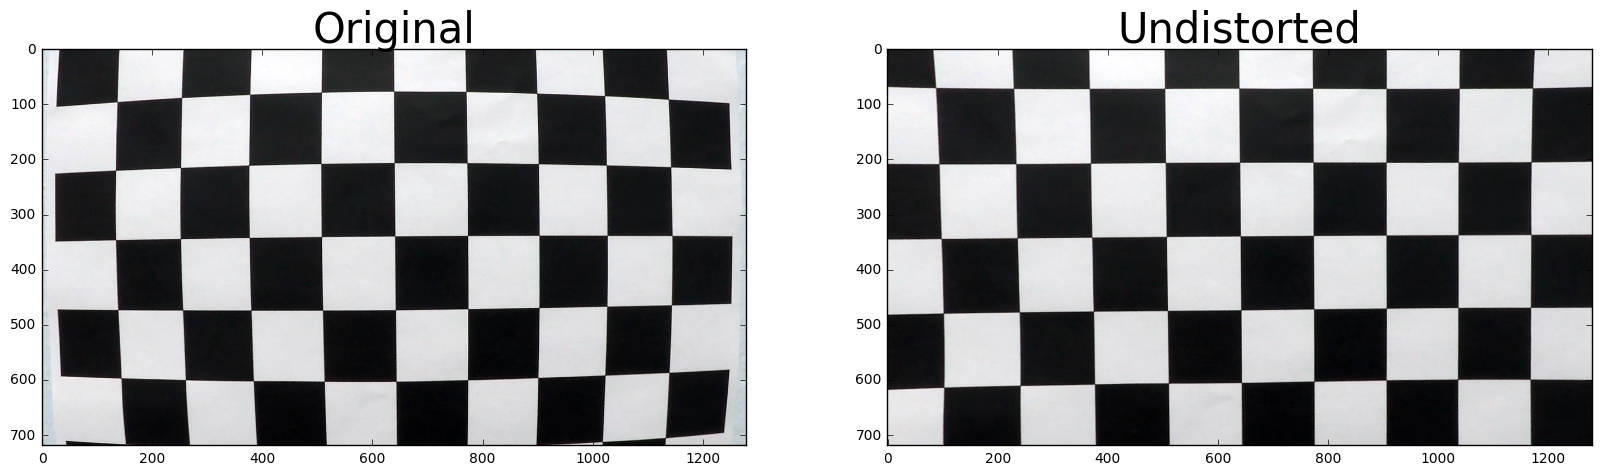

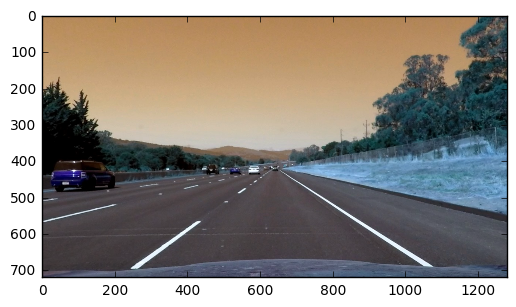

In [48]:
input_distorted = "camera_cal/calibration1.jpg"
output_undistorted = "output_images/undistorted_calibration1.jpg"

def undistort(img):    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, (img.shape[0], img.shape[1]), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

img = cv2.imread(input_distorted)
undist = undistort(img)
cv2.imwrite(output_undistorted, undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted', fontsize=30)

straight_line = cv2.imread("test_images/straight_lines2.jpg")
output_undistorted = "output_images/undistorted_straight_lines2.jpg"
undist = undistort(straight_line)
cv2.imwrite(output_undistorted, undist)
plt.figure(2)
plt.imshow(undist)

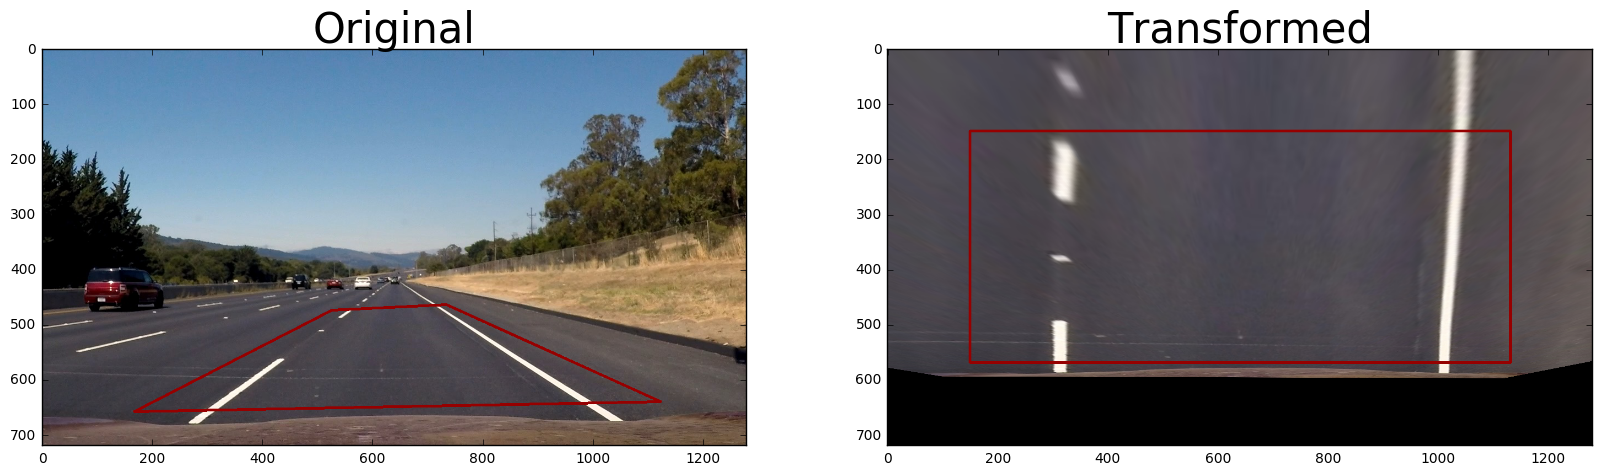

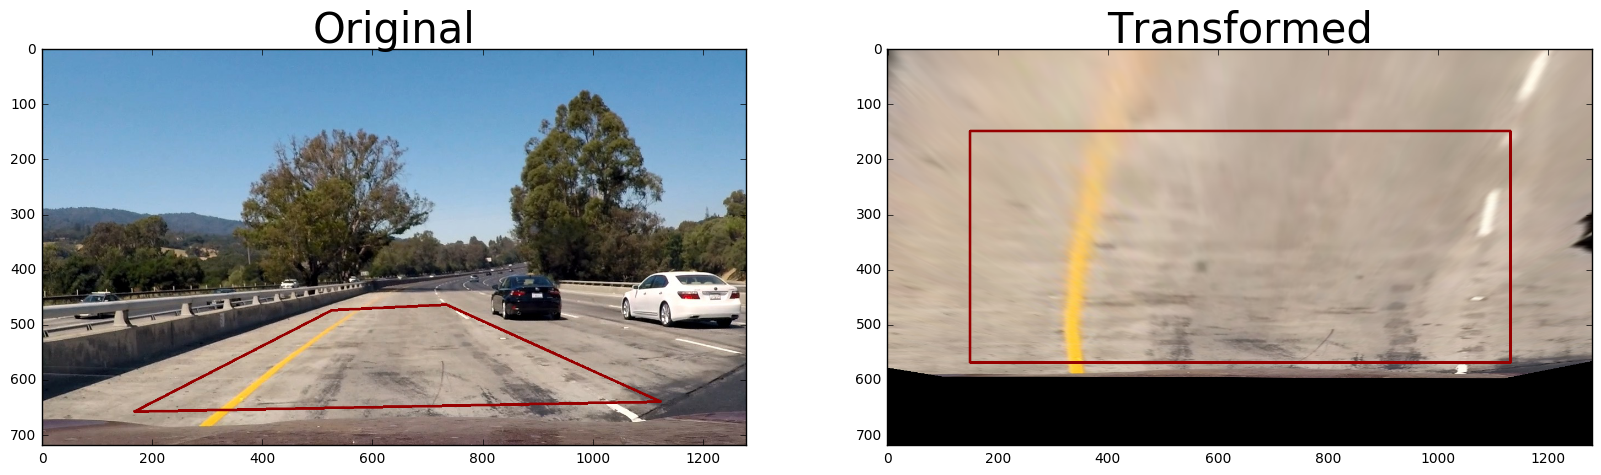

In [26]:
input_transformed = "test_images/straight_lines2.jpg"
output_transformed = "output_images/transformed_straight_lines1.jpg"


img = cv2.imread(input_transformed)
w = img.shape[0]
h = img.shape[1]
gap = 150
src = np.float32([[167,659],[1123,641],[734,465],[526,475]])
dst = np.float32([[gap,w-gap],[h-gap,w-gap],[h-gap,gap],[gap, gap]])

def transform(img):
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    warped = cv2.warpPerspective(img, M, (h,w), flags=cv2.INTER_LINEAR)
    return warped

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

img = mpimg.imread(input_transformed)
trans = transform(undistort(img))
cv2.imwrite(output_transformed, trans)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.polylines(img, np.int32([src]), True, color = (150,0,0), thickness = 3)
cv2.polylines(trans, np.int32([dst]), True, color = (150,0,0), thickness = 3)

ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(trans)
ax2.set_title('Transformed', fontsize=30)

img = mpimg.imread("test_images/test1.jpg")
trans = transform(undistort(img))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
cv2.polylines(img, np.int32([src]), True, color = (150,0,0), thickness = 3)
cv2.polylines(trans, np.int32([dst]), True, color = (150,0,0), thickness = 3)

ax1.imshow(img)
ax1.set_title('Original', fontsize=30)
ax2.imshow(trans)
ax2.set_title('Transformed', fontsize=30)

True

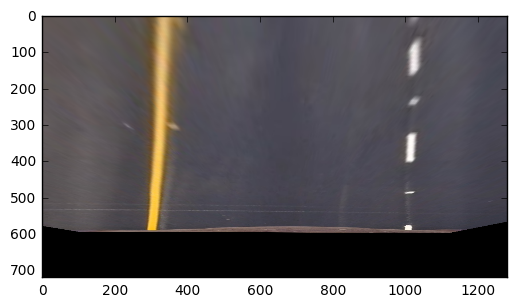

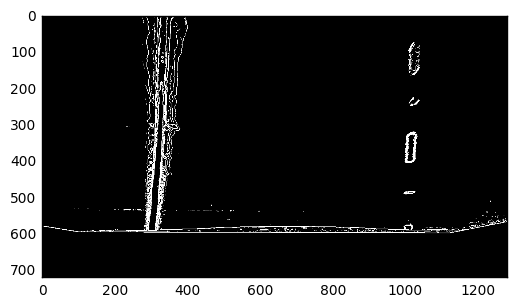

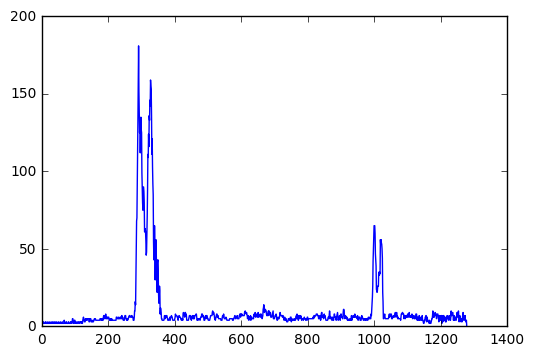

In [59]:

%matplotlib inline

def blur(image, kernel):
    image = cv2.GaussianBlur(image, (kernel,kernel), 0)
    return image


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    binary_output = np.zeros_like(img)
    sobel = img
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1,0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0,1)
    abs_sobel = np.absolute(sobel)
    avg_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output[(avg_sobel >= thresh[0]) & (avg_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # 2) Take the gradient in x and y separately
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1,0)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0,1)
    grad = np.sqrt(np.power(grad_x,2) + np.power(grad_y,2))
    # 3) Calculate the magnitude 
    grad = np.absolute(grad)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.uint8(255 * grad/np.max(grad))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(image)
    # 6) Return this mask as your binary_output image
    binary_output[(scale > mag_thresh[0]) & (scale < mag_thresh[1])] = 1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 2) Take the gradient in x and y separately
    grad_X = cv2.Sobel(image, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    grad_Y = cv2.Sobel(image, cv2.CV_64F, 0,1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    arctan = np.arctan2(np.absolute(grad_Y), np.absolute(grad_X))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(image)
    binary_output[(arctan > thresh[0]) & (arctan < thresh[1])] = 1
    return binary_output

def filter_image_with_lane_line(image):
    
    # Choose a Sobel kernel size
    ksize = 21 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    img = cv2.bitwise_or(hls[:,:,2], hls[:,:,1])
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 130))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 130))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 250))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0,np.pi/2))


    combined = np.zeros_like(dir_binary)
    combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

original = mpimg.imread('./test_images/straight_lines1.jpg')
img = undistort(original)
img = transform(img)
plt.figure(0)
plt.imshow(img)
img = filter_image_with_lane_line(img)
plt.figure(1)
plt.imshow(img, cmap='gray')
plt.figure(2)
histogram = np.sum(img[img.shape[0]/2:,:], axis=0)    
plt.plot(histogram)
img[img >= 1] = 255
img = np.dstack((img, img, img))
cv2.imwrite("output_images/binary_straight_lines1.jpg", img)

In [21]:
def process_image(img):
    img = undistort(img)
    img = transform(img)
    img = filter_image_with_lane_line(img)
    return img

x =process_image(mpimg.imread('./test_images/image-018.jpeg'))
plt.figure()
x[x>0] = 255
y=np.dstack((x,x,x))
cv2.imshow("mat", y)

In [60]:

glob_regex='test_images/*.jpeg'
for f in glob.glob(glob_regex):
    img = mpimg.imread(f)
    img = process_image(img)
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    
    plt.plot(histogram)

348.644007699
392.031831539


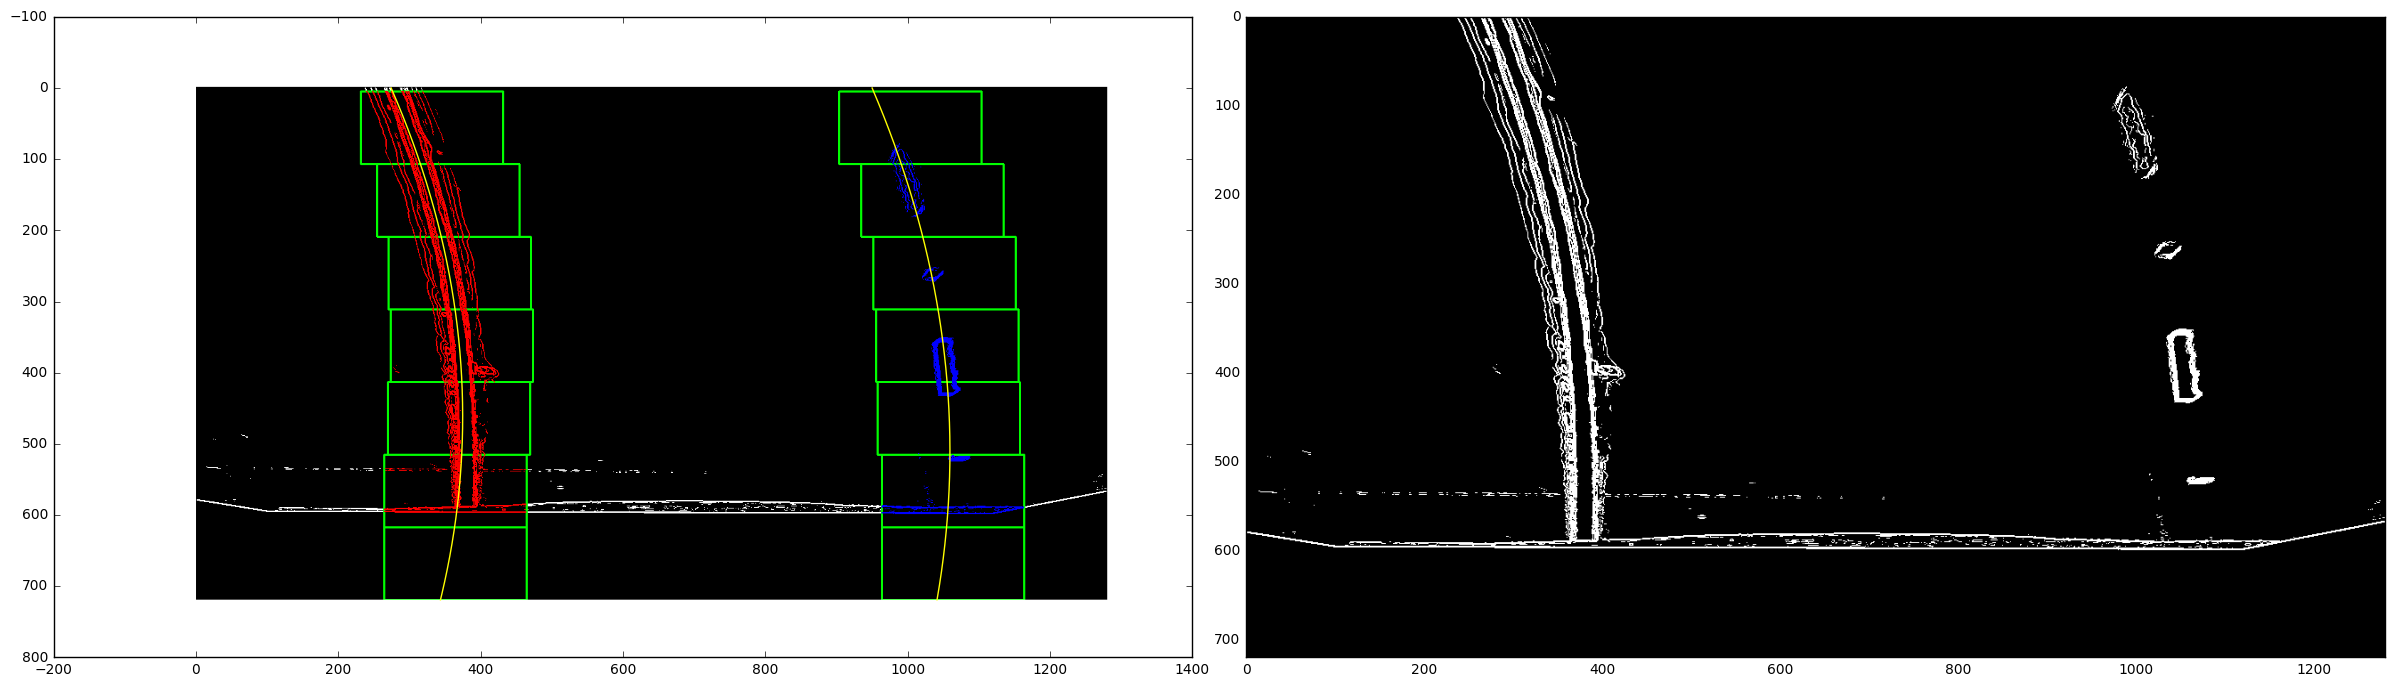

In [76]:
def find_lane(binary_warped, debug=False):
    
    ## FOLLOWING CODE FROM CLASSROOM LECTURE
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 7
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_y_eval = np.max(lefty)
    right_y_eval = np.max(righty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*left_y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*right_y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, left_curverad, right_curverad, left_fitx, right_fitx, ploty, out_img, binary_warped

img_path='test_images/test2.jpg'
left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, ploty, out_img, binary = find_lane(process_image(mpimg.imread(img_path)), True)

f, x = plt.subplots(1, 2, figsize=(24, 20))
x = x.ravel()
f.tight_layout()
print(left_cur)
print(right_cur)
x[0].imshow(out_img)
x[0].plot(left_fitx, ploty, color='yellow')
x[0].plot(right_fitx, ploty, color='yellow')
x[1].imshow(binary, cmap="gray")


In [ ]:
# Merge Gradient + undistort + tranform
def test_all_images():
    glob_regex='test_images/*.jpeg'
    images=[]
    original_images = []
    f, x = plt.subplots(8, 3, figsize=(100, 100))
    x = x.ravel()
    f.tight_layout()
    idx = 0
    for f in glob.glob(glob_regex):
        original_img = cv2.imread(f)
        img = process_image(original_img)
    
        left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, ploty, out_img, binary = find_lane(img, True)
        
        x[3*idx].imshow(original_img, cmap='gray')
        x[3*idx+1].imshow(img, cmap='gray')
        x[3*idx+2].imshow(out_img, cmap='gray')
        
        x[3*idx+2].plot(left_fitx, ploty, color='yellow')
        x[3*idx+2].plot(right_fitx, ploty, color='yellow')

        x[3*idx].axis('off')
        x[3*idx+1].axis('off')
        x[3*idx+2].axis('off')
        idx = idx + 1
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        

test_all_images()

377.236159668 294.081274515


True

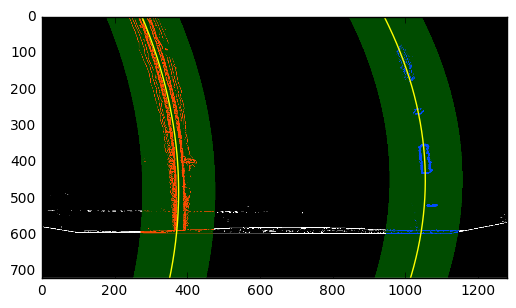

In [68]:
## CODE FROM LECTURE
def next_lane(binary_warped, left_fit, right_fit, debug=True):
    

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_y_eval = np.max(lefty)
    right_y_eval = np.max(righty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    image_size = np.shape(binary_warped)
    # Calculate where the lanes hit the bottom of the image
    left_bottom = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_bottom = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]

    # Next take the difference in pixels between left and right interceptor points
    road_width_in_pixels = right_bottom - left_bottom
    
    calculated_center = (left_bottom + right_bottom) / 2.0
    
    lane_deviation = (calculated_center - image_size[1] / 2.0) * xm_per_pix
    lane_deviation_round = round(lane_deviation, 2)
    
    y_eval = np.max(ploty)
    
    # Calculate the radius of both lane lines
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    # Calculate the mean radius of both lines
    

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        
    return left_fit, right_fit, left_curverad, right_curverad, left_fitx, right_fitx, ploty, out_img, result, lane_deviation_round
        
img = process_image(mpimg.imread('test_images/test2.jpg'))
left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, ploty, out_img, result, deviation = next_lane(img, left_fit, right_fit, True)
print(left_cur, right_cur)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
cv2.imwrite("output_images/polyfit_test2.jpg", result)

True

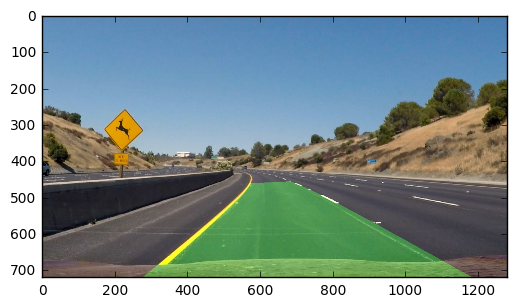

In [78]:
def draw_over_image(original_img, warped, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, 719, num=720)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result

image_path = "test_images/test2.jpg"
img = mpimg.imread(image_path)
bw_img = process_image(img)
result = draw_over_image(img, bw_img, left_fitx, right_fitx)
plt.imshow(result)
cv2.imwrite("output_images/test2.jpg", result)

In [15]:
def merge_to_one_image(main_image, image_with_transform, bw_img, image_with_lane):
    height = int(main_image.shape[0] / 3)
    width = 300
    image_with_transform = cv2.resize(image_with_transform, (width,height))
    
    bw_img = cv2.resize(bw_img, (width,height))
    bw_img[bw_img > 0] = 255
    bw_img = np.dstack((bw_img, bw_img, bw_img))
    
    image_with_lane = cv2.resize(image_with_lane, (width,height))
    
    canvas = np.zeros((img.shape[0], img.shape[1]+width, 3))
    
    canvas[0:main_image.shape[0], 0:main_image.shape[1]] = main_image
    x_from, x_to = main_image.shape[1], main_image.shape[1] + width
    canvas[0:height, x_from: x_to, :] = bw_img
    canvas[height:2*height, x_from:x_to, :] = image_with_lane
    canvas[2*height:3*height, x_from:x_to, :] = image_with_transform
    
    return canvas

In [40]:
first = 0
global left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, prev_left_fitx, prev_right_fitx
weighted = 0.6

def process_image_wrapper(img):
    global first, left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, prev_left_fitx, prev_right_fitx
    bw_img = process_image(img)
    
    if first == 0:
        left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, ploty, box_img, result = find_lane(bw_img, False)
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
    else:
        left_fit, right_fit, left_cur, right_cur, left_fitx, right_fitx, ploty, box_img, result, deviation = next_lane(bw_img, left_fit, right_fit, False)
        left_fitx = weighted * prev_left_fitx + (1-weighted) * left_fitx
        right_fitx = weighted * prev_right_fitx + (1-weighted) * right_fitx
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
        
    
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
    result = draw_over_image(img, bw_img, left_fitx, right_fitx)
#    cv2.imshow('img1', result)
    image_with_transform = transform(img)
    result = merge_to_one_image(result, image_with_transform, bw_img, box_img)
    
    if first != 0:
        
        curv_mean = 'Curvature radius (m): ' + str(abs(round((left_cur + right_cur) / 2.0, 0)))

        text_lane = 'Offset from center (m): ' + str(abs(deviation))

        cv2.putText(result, curv_mean, (35, 35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
        cv2.putText(result, text_lane, (35, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)
        
    first = 1
    return result

In [41]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_small_video.mp4'
input_file = 'small_video.mp4'
first = 0
count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(process_image_wrapper) 
out_clip.write_videofile(output_file, audio=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[MoviePy] >>>> Building video processed_small_video.mp4
[MoviePy] Writing video processed_small_video.mp4




  0%|          | 0/189 [00:00<?, ?it/s]

  1%|          | 1/189 [00:01<04:37,  1.48s/it]

  1%|          | 2/189 [00:02<04:33,  1.46s/it]

KeyboardInterrupt: 